In [1]:
!nvcc -V
!gcc --version
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth \
      -O checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:15:58tcmalloc: large alloc 1147494400 bytes == 0x39b4a000 @  0x7fcd3465a615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x59

In [3]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-06-08 11:37:08--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.233
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  2.15MB/s    in 3.1s    

2022-06-08 11:37:14 (2.15 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



In [4]:
!apt-get -q install tree
!tree kitti_tiny

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (155 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
kitti_tiny
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpeg

In [54]:
from mmcv import collect_env
collect_env()
import torch, torchvision
import mmdet
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

In [56]:
import copy
import os.path as osp
import mmcv
import numpy as np
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiTinyDataset(CustomDataset):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpeg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

KeyError: ignored

In [59]:
round(2e-4,6)

0.0002

In [63]:
from mmcv import Config
cfg = Config.fromfile('/content/model.py')

In [64]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'KittiTinyDataset'
cfg.data_root = 'kitti_tiny/'

cfg.data.test.type = 'KittiTinyDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/image_2'

cfg.data.train.type = 'KittiTinyDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittiTinyDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.model.bbox_head.num_classes = 3

cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.0001
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='DeformableDETR_SWIN',
    backbone=dict(
        type='SWIN',
        embed_dims=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.2,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        with_cp=False,
        convert_weights=True,
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth'
        )),
    neck=dict(
        type='ChannelMapper',
        in_channels=[96, 192, 384, 768],
        kernel_size=1,
        out_channels=256,
        act_cfg=None,
        norm_cfg=dict(type='GN', num_groups=32),
        num_outs=4),
    bbox_head=dict(
        type='DeformableDETRHead',
        num_query=25,
        num_classes=3,
       

In [41]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

datasets = [build_dataset(cfg.data.train)]
model = build_detector(cfg.model)
model.CLASSES = datasets[0].CLASSES

cfg.device='cuda' 
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 10.1 task/s, elapsed: 2s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-06-08 12:58:06,495 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 107  | 0.952  | 0.867 |
| Pedestrian | 13  | 28   | 0.846  | 0.763 |
| Cyclist    | 7   | 43   | 0.429  | 0.134 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.588 |
+------------+-----+------+--------+-------+
2022-06-08 12:58:06,498 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5880, mAP: 0.5878


/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


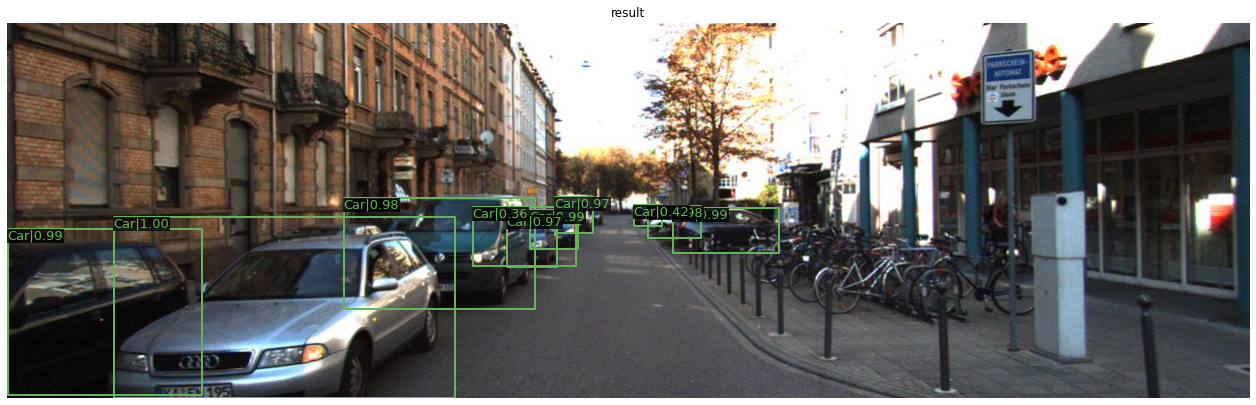

In [ ]:
img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


In [45]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

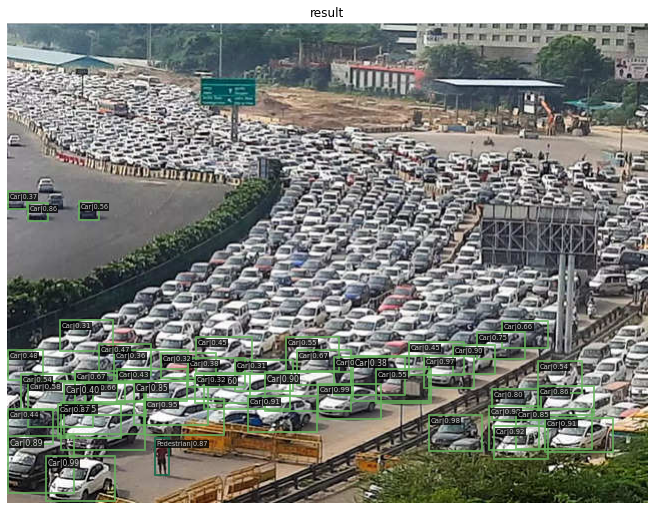

In [47]:
img = mmcv.imread('/content/cars_traffic.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)
